In [1]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./00_setup.py").load_module()

## Random Hierarchy for NAICS (data generator randomization)
Neural Network With NAICS Embedding Layer + dummy hieararchy. Add NAICS embedding to model.  Add additional dummy levels to the hieararchy.   Modify training data to inject 10% 1 values for all levels.  Use a data generator to shuffle randomiztion

Use the dataset with no missing values. 

*This script takes about 2 hours on my MacBook Air*

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [3]:
from pathlib import Path
import importlib, pickle
from sklearn import model_selection

In [4]:
import pandas as pd
import os
import re

import keras
from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
from tensorflow.keras.layers import Dense, Dropout, Input, Embedding, \
    Concatenate, Reshape, concatenate, Flatten
import tensorflow.keras.metrics as km

In [6]:
from sba_nn.sba_nn import sbnn_metrics, sbnn_model 
from sba_nn.sba_nn.sbnn_model import CatInjectGenerator

## Input Data

In [7]:
with open(Path(setup.temp_path).joinpath('41_DATA_naics_max_encodings.pkl'), 'rb') as fin:
    naics_max_levels= pickle.load(fin)
naics_max_levels

{'NAICS_orig': 1170, 'rgrp_345': 337, 'rgrp_106': 107, 'rgrp_020': 21}

In [8]:
grp_features = list(naics_max_levels.keys())

In [9]:
sba_loans = pd.read_parquet(Path(setup.temp_path).joinpath('01_DATA_transformed_nomiss.parquet'))

In [10]:
naics_new = pd.read_parquet(Path(setup.temp_path).joinpath('41_DATA_naics_groups_loans.parquet'))

In [11]:
sba_loans = sba_loans.drop(columns=grp_features, errors='ignore') \
    .merge(naics_new[['LoanNr_ChkDgt'] + grp_features], on='LoanNr_ChkDgt')

In [12]:
with open(Path(setup.temp_path).joinpath('01_DATA_features.pkl'), 'rb') as fin:
    imputer_features = pickle.load(fin)

# Features

In [13]:
# Numeric features
features_numeric = [f for f in imputer_features if 'NAICS' not in f]
features_numeric_len = len(features_numeric)
print(features_numeric)

['NoEmp', 'CreateJob', 'LowDoc', 'DisbursementGross', 'new_business', 'urban_flag', 'franchise_flag', 'missingindicator_LowDoc', 'missingindicator_new_business', 'missingindicator_urban_flag']


In [14]:
# Use analagous embedding dimensions
features_naics_hier = ['NAICS_4', 'NAICS_3', 'NAICS_sector']
features_grp_all = ['NAICS'] + features_naics_hier
grp_emb_dim = [setup.nn_naics_embed_size_dict[n] for n in features_grp_all]

In [15]:
print(naics_max_levels)
print(grp_emb_dim)

{'NAICS_orig': 1170, 'rgrp_345': 337, 'rgrp_106': 107, 'rgrp_020': 21}
[8, 4, 4, 2]


##### Datasets for train, validation

In [16]:
X = sba_loans[['dset', 'LoanNr_ChkDgt'] + features_numeric + grp_features].set_index('LoanNr_ChkDgt').sort_index()

In [17]:
X_train = X[X['dset'] == 'train'].drop(columns='dset')
y_train = sba_loans[sba_loans['dset'] == 'train'].set_index('LoanNr_ChkDgt').sort_index()['target']
print(f'training X: {X_train.shape}, y:{y_train.shape}')

training X: (446848, 14), y:(446848,)


In [18]:
X_val = X[X['dset'] == 'val'].drop(columns='dset')
y_val = sba_loans[sba_loans['dset'] == 'val'].set_index('LoanNr_ChkDgt').sort_index()['target']
print(f'val X: {X_val.shape}, y:{y_val.shape}')

val X: (95604, 14), y:(95604,)


## Create, fit model

In [19]:
this_model = sbnn_model.create_emb_model(features_numeric_len,
                                         list(naics_max_levels.values()),
                                         grp_emb_dim,
                                         naics_embedding_names = grp_features,
                                         hidden_size = setup.nn_layer_sizes,
                                         activation='tanh',
                                         lr=setup.nn_learning_rate,
                                         opt_func = setup.nn_optimizer,
                                         dropout = setup.nn_dropout)

2024-05-29 17:30:42.164476: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-05-29 17:30:42.164517: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-05-29 17:30:42.164594: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-05-29 17:30:42.164708: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-29 17:30:42.164740: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [20]:
this_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_naics_00 (InputLayer  [(None, 1)]                  0         []                            
 )                                                                                                
                                                                                                  
 input_naics_01 (InputLayer  [(None, 1)]                  0         []                            
 )                                                                                                
                                                                                                  
 input_naics_02 (InputLayer  [(None, 1)]                  0         []                            
 )                                                                                            

In [21]:
generator = CatInjectGenerator(X_train, y_train,
                               categorical_columns=grp_features,
                               batch_size = setup.nn_batch_size,
                               injection_rate = 0.1,
                               injection_value = 1)

In [22]:
callback = keras.callbacks.EarlyStopping(patience=3)

In [23]:
this_history = this_model.fit(generator,
                              batch_size=setup.nn_batch_size,
                              epochs = setup.nn_epochs,
                              validation_data=([X_val[features_numeric]] + [X_val[f] for f in grp_features], 
                                               y_val),
                              shuffle=True,
                              callbacks=[callback])

Epoch 1/20


2024-05-29 17:30:43.753466: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


13962/13964 [============================>.] - ETA: 0s - loss: 0.4631 - auc: 0.3350 - auc_1: 0.6976

2024-05-29 17:34:53.619603: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


13964/13964 [==============================] - 275s 20ms/step - loss: 0.4631 - auc: 0.3350 - auc_1: 0.6976 - val_loss: 0.4544 - val_auc: 0.3697 - val_auc_1: 0.7226
Epoch 2/20
13964/13964 [==============================] - 279s 20ms/step - loss: 0.4554 - auc: 0.3564 - auc_1: 0.7144 - val_loss: 0.4522 - val_auc: 0.3778 - val_auc_1: 0.7273
Epoch 3/20
13964/13964 [==============================] - 285s 20ms/step - loss: 0.4534 - auc: 0.3626 - auc_1: 0.7190 - val_loss: 0.4517 - val_auc: 0.3801 - val_auc_1: 0.7283
Epoch 4/20
13964/13964 [==============================] - 291s 21ms/step - loss: 0.4521 - auc: 0.3670 - auc_1: 0.7219 - val_loss: 0.4502 - val_auc: 0.3825 - val_auc_1: 0.7299
Epoch 5/20
13964/13964 [==============================] - 273s 20ms/step - loss: 0.4512 - auc: 0.3696 - auc_1: 0.7234 - val_loss: 0.4503 - val_auc: 0.3846 - val_auc_1: 0.7301
Epoch 6/20
13964/13964 [==============================] - 270s 19ms/step - loss: 0.4506 - auc: 0.3719 - auc_1: 0.7243 - val_loss: 0.4507

In [24]:
this_history_df = sbnn_model.process_history(this_history)

In [25]:
this_history_df.to_csv(Path(setup.temp_path).joinpath('43_REPORT_fit_history.csv'))

<Axes: >

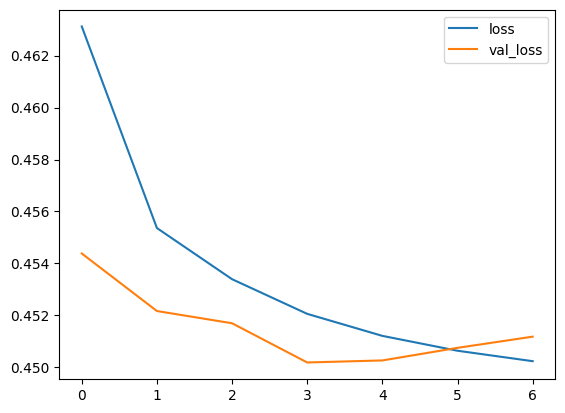

In [26]:
this_history_df[['loss', 'val_loss']].plot()

<Axes: >

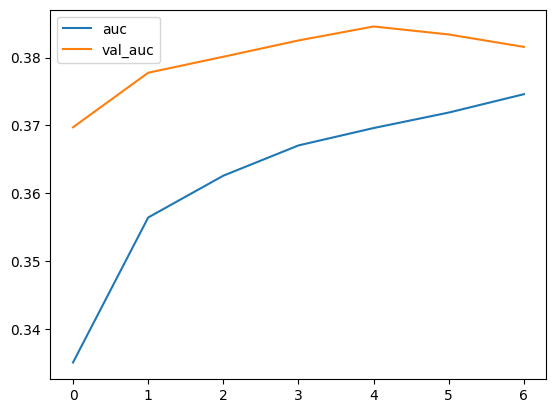

In [27]:
this_history_df[['auc', 'val_auc']].plot()

<Axes: >

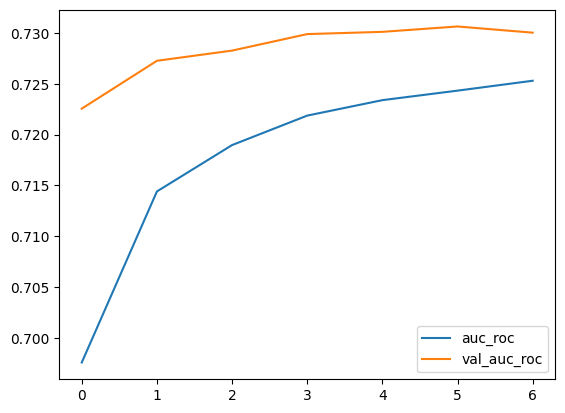

In [28]:
this_history_df[['auc_roc', 'val_auc_roc']].plot()

In [29]:
this_model.save(Path(setup.temp_path).joinpath('43_DATA_model.keras'),save_format='tf')

## Predictions on all data

In [30]:
all_predictions = this_model.predict([X[features_numeric]]+ [X[f] for f in grp_features])

   42/21735 [..............................] - ETA: 54s 

2024-05-29 18:02:49.727261: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


21735/21735 [==============================] - 44s 2ms/step


In [31]:
all_predictions_df = pd.DataFrame(all_predictions, index=X.index) \
    .set_axis(['predict_prob'], axis=1) \
    .reset_index() \
    .merge(sba_loans[['target', 'LoanNr_ChkDgt', 'dset', 'dset_naics_holdout', 'NAICS']], 
           on='LoanNr_ChkDgt')

In [32]:
all_predictions_df[['predict_prob', 'target']].corr(method='spearman')

,predict_prob,target
predict_prob,1.000000,0.320519
target,0.320519,1.000000


##### Threshold Tune & Binary Predictions
Using training probability predictions

In [33]:
all_pred_train = all_predictions_df[all_predictions_df['dset'] == 'train']

In [34]:
thresh_tune_data = sbnn_metrics.get_f1_frame(all_pred_train['target'], 
                                        all_pred_train['predict_prob'])

In [35]:
thresh_tune_data.sort_values('f1', ascending=False, inplace=True)
thresh_tune_data.head(3)

,thresh,f1
12,0.24,0.452726
13,0.26,0.452699
11,0.22,0.450457


In [36]:
best_thresh = thresh_tune_data['thresh'].iloc[0]
best_thresh

0.24

##### Append binary predictions to probability predictions

In [37]:
all_predictions_df['predict_bin'] = sbnn_metrics.get_binary_predictions(all_predictions_df['predict_prob'], best_thresh)

In [38]:
all_predictions_df['predict_bin'].value_counts(normalize=True, dropna=False)

predict_bin
0    0.555037
1    0.444963
Name: proportion, dtype: float64

In [39]:
all_predictions_df.to_parquet(Path(setup.temp_path).joinpath('43_DATA_predictions.parquet'))

## Metrics

In [40]:
metrics_dset_df = all_predictions_df.groupby('dset') \
    .apply(lambda x: sbnn_metrics.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_test_df = all_predictions_df[all_predictions_df['dset'] == 'test'] \
    .groupby(['dset', 'dset_naics_holdout']) \
    .apply(lambda x: sbnn_metrics.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_df = pd.concat([metrics_dset_df, metrics_test_df])
metrics_df.to_csv(Path(setup.temp_path).joinpath('43_REPORT_metrics.csv'), index=True)
metrics_df

,dset,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score,dset_naics_holdout
0,test,0.635539,0.439588,0.318619,0.708636,0.363508,0.719030,NaN
1,train,0.646276,0.452726,0.329496,0.723197,0.386168,0.734076,NaN
2,val,0.645182,0.451828,0.329756,0.717401,0.381759,0.730068,NaN
0,test,0.641962,0.446329,0.325405,0.710276,0.378498,0.725597,0.0
1,test,0.624863,0.428553,0.307678,0.705857,0.332465,0.707481,1.0
